# STARDIS

In [1]:
# Useful for development

%load_ext autoreload
%autoreload 2

In [2]:
# Import necessary code

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage

from stardis.base import run_stardis

from astropy import units as u, constants as const

Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

In [3]:
# Create array of wavelengths and run STARDIS

tracing_lambdas = np.arange(1000, 10000, 1) * u.Angstrom

sim = run_stardis(
    'kurucz_cd23_chianti_H_He.h5',  
    'data/marcs/sun.mod',
    tracing_lambdas,
    wbr_fpath="data/wishart_broad_reinhardt_cross_section.dat"
)

In [4]:
# Smooth out spectrum

smooth_spectrum = ndimage.gaussian_filter1d(sim.spectrum_lambda, 5)

In [5]:
# Load actual sun spectrum

sun_spec = pd.read_csv('data/solar_data/NewGuey2003.txt', skiprows=20, delim_whitespace=True, names=['wave', 'flux'])
sun_spec['wave'] *= 10
sun_spec['flux'] = u.Quantity(sun_spec['flux'].to_numpy(), "W/(m2 nm)").to("erg/(s cm2 AA)").value

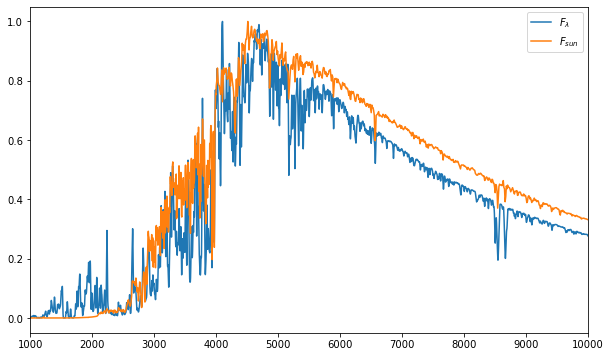

In [6]:
# Plot spectra

#%matplotlib notebook

plt.figure(figsize=(10,6))
plt.plot(sim.lambdas, smooth_spectrum/max(smooth_spectrum), label="$F_\lambda$")
plt.plot(sun_spec.wave, sun_spec.flux/max(sun_spec.flux), label="$F_{sun}$")

plt.xlim((1000,10000))
plt.legend();